[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Humboldt-WI/adams/blob/master/demos/nlp/sentiment_analysis.ipynb)

# Prediction of online review sentiment

Sentiment analysis is one of the most popular applications for text classification. It is also interesting from a business perspective. For example, many companies have an interest in analyzing text data emerging in social media to understand how consumers value their products, service, brands, etc.

The goal of sentiment analysis is to model the polarity of a piece of text, whether it is rather positive or rather negative. We can frame this task as a binary classification problem, with labels of one and zero indicating positive or negative sentiment, respectively. That is the approach we will take today. Other options  could involve modeling a three-level target (positive, neutral, negative) or a numeric target variable the values of which represent different strengths of polarity (e.g., between +5 and -5). Whenever approaching the sentiment analysis task by supervised learning, we depend on having some data with sentiment labels. That is often the real challenge in practice — where do the labels come from? — and explains why many labeled data sets re-occur in papers.

We will once more consider the (preprocessed) movie review data set. Originally gathered and studied by Maas et al. (https://www.aclweb.org/anthology/P11-1015), the data set is used in numerous papers on sentiment analysis. In fact, it is so popular that it is part of the [`Keras` data set collection](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/) and also used in official demo codes available in the `Keras` documentation. While we could use the [`Keras` version of the data](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb), which is the easiest approach to start working with it, we have already invested a lot of time into cleaning and preparing the IMDB reviews in the last session. Therefore, we will stick to our own version of the data. 

We will apply different modeling approaches to predict review sentiment, from a simple dictionary-based approach over conventional supervised machine learning to several deep learning techniques. Here is the outline of the session.
  
 1. [Preliminaries](#prelim)<br>
 2. [Dictionary-based sentiment analysis](#lexi)<br>
 3. [Text data representation](#rep)<br>
 4. [Sentiment classifiers](#senti)<br>
    4.1 [Linear model](#lasso)<br>
    4.2 [Deep learning-based models](#pB) 
        4.2.1 Feed-forward neural network 
        4.2.2 Recurrent neural network based on GRU 
        4.2.3 GRU with pre-trained IMDB embedding 
        4.2.4 GRU with pre-trained GloVe embedding 
        4.2.5 Bidirectional GRU with pre-trained GloVe embedding 

Let's get started.

<a id="prelim"></a>

## 1. Preliminaries

To set up our environment we load the IMDB 50K review data set and also the list of cleaned reviews. We then add the cleaned reviews to the data set to have everything in one place. It is a good idea to examine a few reviews and make sure that the original version and the cleaned version match. Ones this is confirmed, you can safely discard the raw review text to save memory. Finally, we update the coding of our target variable and encode positive and negative reviews as one and zero, respectively.  

The notebook sets a new milestone in terms of demand for computational resources. We recommend running the notebook  in **Colab or another cloud-based platform of your choice**.  

In [75]:
# Import standard libraries
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

In [154]:
# Create a global variable to idicate whether the notebook is run in Colab
import sys
IN_COLAB = 'google.colab' in sys.modules

# Configure variables pointing to directories and stored files 
if IN_COLAB:
    # Mount Google-Drive
    from google.colab import drive
    drive.mount('/content/drive')
    DATA_DIR = '/content/drive/My Drive/notebooks/Git/adams/demos/nlp/'  # adjust to Google drive folder with the data if applicable
    print('Make sure to uncomment the below cell to install pysentiment2 from PyPI')
else:
    DATA_DIR = './' # adjust to the directory where data is stored on your machine (if running the notebook locally)

sys.path.append(DATA_DIR)

CLEAN_REVIEW = DATA_DIR + 'imdb_clean_full_v2.pkl'   # List with tokenized reviews after standard NLP preparation
IMBD_EMBEDDINGS = DATA_DIR + 'w2v_imdb_full_d100_e500.model'
GLOVE_EMBEDDINGS = '/content/drive/MyDrive/data/glove.6B.50d.txt'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Make sure to uncomment the below cell to install pysentiment2 from PyPI


In [77]:
#!pip install pysentiment2

### Loading the data
We load the data frame with the original and cleaned reviews. The original version does not matter for this session. We will delete them to save memory. 

In [78]:
import pickle
with open(CLEAN_REVIEW,'rb') as path_name:
    df = pickle.load(path_name)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   review        50000 non-null  object
 1   sentiment     50000 non-null  object
 2   review_clean  50000 non-null  object
dtypes: object(3)
memory usage: 1.1+ MB


In [79]:
df.head()

,review,sentiment,review_clean
0,One of the other reviewers has mentioned that ...,positive,one reviewer mention watch oz episode hooked r...
1,A wonderful little production. <br /><br />The...,positive,wonderful little production film technique una...
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,basically family little boy jake think zombie ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter love time money visually stun film watc...


In [80]:
# Drop original review text
df.drop('review', axis=1, inplace=True)

# Binary-encode the target variable
df['sentiment'] = df['sentiment'].map({'positive' : 1, 'negative': 0})
df['sentiment'].value_counts()

1    25000
0    25000
Name: sentiment, dtype: int64

### Downsampling the data to increase speed
One more thing before moving on. You should decide whether you want to proceed with the full data frame (i.e., 50K reviews) or draw a random sample to decrease the runtime of the following examples. Using all the data is feasible on any descent computer but prepare for a bit of waiting when training our neural networks. Here is a little bit of code to reduce the amount of data.

In [81]:
# Draw a random sample of n reviews to increase the speed of the following steps
n = 5000
np.random.seed(111)
ix = np.random.randint(0, high=df.shape[0]-1, size=n)
df = df.loc[ix, :]
df.reset_index(drop=True, inplace=True)
df

,sentiment,review_clean
0,0,start watch believe character particular relat...
1,0,totally unfunny movie top pathetic unrealistic...
2,0,absolutely nothing redeem movie take sleazy st...
3,0,warn may contain spoiler huge problem movie to...
4,1,surprising majority high rat vote submit femal...
...,...,...
4995,1,ladislas curiosity insect cinema meld short fi...
4996,0,movie even save grace bad good truly appal clo...
4997,0,documentary nomadic persian make treacherous t...
4998,1,film move cinderella story forward early make ...


Before moving on with developing sentiment classification models, we partition our data into a training and a hold-out test set.

In [82]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['review_clean'], df['sentiment'], test_size=0.25, random_state=111)

<a id="lexi"></a>

## 2. Dictionary-based sentiment analysis

A simple approach to rate the sentiment of a text is to literally model it as the sum of its parts through the sentiment of each word. `pysentiment2` is a package containing several English word sentiment dictionaries. Word scores are either negative (-1), neutral (0) or positive (1). On a sentence level the polarity score is the average of positive and negative words (neutral words are ignored). The Harvard IV-4 dictionary, which we will use, consists of 3,642 coded words. Note that you will need to install the library before being able to run the following code.

In [83]:
import pysentiment2 as ps
dc = ps.HIV4() # import Harvard IV-4 dictionary

def get_sentiment_score(text):
    score = round(dc.get_score(dc.tokenize(text))['Polarity'], 2)
    return score

We look up the sentiment score for each word in turn and sum up the sentiment values over words. Here are a few examples. Quite easy, isn't it?

In [84]:
#* Some examples how to rate texts. Larger values indicate stronger positive feelings
examples = ["What a marvelous evening, the weather is simply delightful. Wonderful!", 
            "I am devastated, the donuts are not what they once were – disgusting.",
            "To be or not to be?"
           ]
for txt in examples:
    print(txt, "\t -> Sentiment score:", get_sentiment_score(txt))

What a marvelous evening, the weather is simply delightful. Wonderful! 	 -> Sentiment score: 1.0
I am devastated, the donuts are not what they once were – disgusting. 	 -> Sentiment score: -1.0
To be or not to be? 	 -> Sentiment score: 0.0


In [85]:
get_sentiment_score('bad')

-1.0

### Sentiment score calculation  
Since we already have a data frame, why not add the sentiment score of every review as a new column. This is a nice use case for the `.apply()` function that Pandas data frames support. We score the cleaned version of the review. If you fancy a little exercise, consider to also score the original review text and compare the differences between the two scores. You could then identify reviews where the sentiment scores differ substantially between the original and cleaned text. That might point to some issues in our data cleaning. 

In [86]:
# Add the Afinn scores to our data frame 
# Caution: if you use the full data set of 50K reviews, the scoring will take a while.
start = time.time()
df['sentiment_score'] = df['review_clean'].apply(get_sentiment_score)
end = time.time()

print('Processed {} reviews in {:.0f} sec.'.format(df.shape[0], end-start))

Processed 5000 reviews in 12 sec.


count    5000.000000
mean        0.159724
std         0.317145
min        -1.000000
25%        -0.050000
50%         0.150000
75%         0.370000
max         1.000000
Name: sentiment_score, dtype: float64

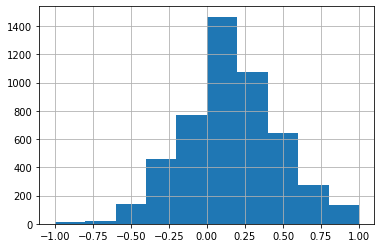

In [87]:
df['sentiment_score'].hist(); 
df['sentiment_score'].describe() # overall rather positive

### Sentiment classifier assessment
We can treat the sentiment scores as class predictions. Applying a classification cut-off of zero, we posit that every review with a positive score is classified as positive, and negative otherwise. We can then examine the predictive accuracy of the dictionary-based classifier using standard performance measures for binary classification. Since we will do so a couple of times, we put the code in a function.

In [88]:
# Assess sentiment classification models 
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

def assess_sentiment_classifier(ytest, yhat, cut_off=0.5, plot_roc=True):
    """
        Helper function to assess a classification model in terms of the AUC
        and classification accuracy. We calculate the latter by comapring
        continuous (e.g., probabilistic) classifier predictions to a cut_off.
        Cases where the prediction exceeds the cut-off are classified as 
        positive.
    """
    # Calculate discrete class predictions
    yhat_c = np.where(yhat>cut_off, 1, 0)
    
    # Calculate classification accuracy and AUC
    acc = accuracy_score(ytest, yhat_c)
    auc = roc_auc_score(ytest, yhat)
    
    # Confusion matrix 
    cmat = confusion_matrix(ytest, yhat_c)
    
    # ROC analysis
    if plot_roc==True:
        fpr, tpr, _ = roc_curve(ytest, yhat)
        plt.plot(fpr,tpr, label="AUC={:.4}".format(auc));
        plt.plot([0, 1], [0, 1], "r--")
        plt.ylabel('True positive rate')    
        plt.xlabel('False positive rate')    
        plt.legend(loc='lower right')
        plt.show();
    
    return(auc, acc, cmat)

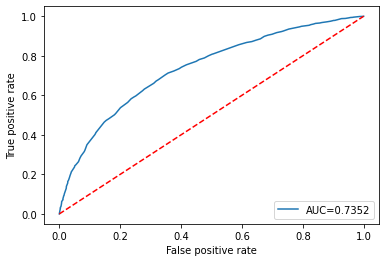

Lexicon-based sentiment classifier:	AUC=0.7352	Accuracy=0.6528


In [89]:
# Assess lexicon-based sentiment classifier
auc, acc, cmat = assess_sentiment_classifier(ytest=df['sentiment'], yhat=df['sentiment_score'], cut_off=0)
print("Lexicon-based sentiment classifier:\tAUC={:.4f}\tAccuracy={:.4f}".format(auc, acc))

In [90]:
# Confusion matrix 
cmat

array([[1231, 1257],
       [ 479, 2033]])

The ROC curve looks good, whereas the confusion matrix suggests that our dictionary-based classifier is biased towards positive reviews. Note that your result might differ depending on which data you are using (all reviews, random sample). Finally, note that our performance estimates come from the whole data. That is ok since the lexicon-based approach does not involve training. Therefore, there is no risk of overfitting and no need for data partitioning.
<br>Since we are about to create more models, it makes sense to create a container in which we store the results of different models. Good options are either a dictionary or a data set. In this notebook, we use the latter approach. To ensure comparability across different approaches, we will re-calculate the performance of the lexicon-based model for the observations of the test set.

In [91]:
# Extract test set cases 
yhat = df.loc[X_test.index, 'sentiment_score']

# Compute test set performance
auc, acc, _ = assess_sentiment_classifier(y_test, yhat, cut_off=0, plot_roc=False)

# We will create many more models. Let's put every model's score into a data frame
df_scores = pd.DataFrame(index=['Acc', 'AUC'], columns=['Lexicon'], data=[acc, auc])
df_scores

,Lexicon
Acc,0.651200
AUC,0.736553


<a id="rep"></a>

## 3. Text data representation
For the next models, we need to represent the text data in a numeric format, which the learning algorithms can process. The specific form of the data depends on the type of learning algorithm. Traditional machine learning algorithms use some form of count vectorization, meaning that the words in a text are replaced by their number of occurrence in that text. This format is also called the **document-term matrix (DTM)**. A tabular data structure in which rows are documents (e.g., reviews in our case) and the columns are the unique words in the vocabulary. Given that a document is seen as a **bag of words**, BoW is just another popular name to refer to corresponding text representations. You can find many sources on the Internet such as [this one](https://www.analyticsvidhya.com/blog/2020/02/quick-introduction-bag-of-words-bow-tf-idf/) to obtain a more comprehensive explanation of the BoW model if interested. Since our focus is deep learning, we will not go there.  However, let's note one important caveat of the BoW approach. The size of the vocabulary is typically very large. For example, according this [Wikipedia page](https://en.wikipedia.org/wiki/List_of_dictionaries_by_number_of_words), there are about 470K unique words in the English language. Making every unique word a feature in the DTM, our matrix will be high dimensional. Stemming can help a bit but **high-dimensionality** is one key disadvantage of representing data in form of a DTM. We will address this issue by developing a LASSO classifier that is robust toward dimensionality.
<br>
One advantage of word vectors over the BoW approach is that they avoid high dimensionality by embedding words in a lower dimensional space. Using word vectors, a document is represented as a **sequence of words** in which each word is represented by its embedding. This is the data structure that we use for our deep learning-based models. 
<br>
In order to create the two text representations for traditional machine learning classifiers and deep learning classifiers, we use the class `Tokenizer` from the `Keras` text processing API. Libraries like `scikit-learn` and others provide similar functionality (see, e.g., [here](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)). When using `Keras`, our first task is to create a tokenizer object and 'train' it, a bit like with models, on our text data. To that end, we use the function `fit_on_texts`. Afterwards, we can use two functions for converting our text into a BoW or a sequence of words for machine and deep learning models, respectively. These functions go by the telling names `texts_to_matrix()` and `texts_to_sequences()`, respectively. We illustrate both of them in the following. But let's first build the vocabulary. We will need to decide how large our vocabulary should be. In practice, that can be a tough decision, the pros and cons being potentially higher accuracy when using many/all words in the text corpus versus faster computations when dropping some infrequent words. We just make a somewhat arbitrary choice in this notebook but remember that the **vocabulary size** is a meta-parameter that you will want to examine when working on a serious case.

In [92]:
# Build vocabulary using Keras
from keras.preprocessing.text import Tokenizer
NUM_WORDS = 2500  # 2.5K is a rather small vocabulary. This choice is only to increase speed. Increase the setting and check whether you can raise performance

# Create tokenizer object and build vocab from the training set
tok = Tokenizer(NUM_WORDS, oov_token=1)  # We fit the tokenizer to the training set reviews. The test set might include
tok.fit_on_texts(X_train)  # words that are not part of the training data. The argument oov_token ensures that such new words are mapped to the specified index

The fitted tokenizer object exposes several methods that summarize what was learned and facilitates looking at the internal data from different perspectives. Here are a few examples:

In [93]:
# On how many documents did we train?
print(tok.document_count)

3750


In [94]:
# How many unique words?
len(tok.word_counts)

25658

In [95]:
# A dictionary of words storing in how many documents a word appeared
word = 'film'  
n = tok.word_docs[word]
print('The word <{}> appeared in {} reviews.'.format(word, n))

The word <film> appeared in 2164 reviews.


### BoW representation for machine learning models
Time to create our input data for traditional machine learning. Let's first showcase the code and discuss it thereafter.

In [96]:
# Count-based vectorization of the data
X_train_bow = tok.texts_to_matrix(X_train, mode='count')  # check the function documentation for other modes than count
X_train_bow.shape  

(3750, 2500)

Makes sense. We obtain a matrix with as many rows as there are reviews in the training set and as many columns as we have words in the vocabulary. Remember that we have set a cut-off above and consider only the top most frequent words. So what our ML model is going to see is this:

In [97]:
# Snipped of the representation of the first training example
X_train_bow[0, 0:9]

array([ 0., 36.,  2.,  1.,  0.,  0.,  1.,  0.,  7.])

The numbers are the counts how many times a word appeared in a review and the rows are the individual reviews. In addition to high dimensionality, another disadvantage of the BoW representation is that word order is ignored. Hence, it is irrelevant in which order the words appear in the columns. The tokenizer object has its internal dictionaries to keep track of which word appears at which position in the columns. You can access the corresponding dictionaries if you want. For example, to find the words by their index, you can use `index_word`, whereas `word_index` facilitates querying the index of a given word. Let's try to make sense out of the above counts by querying the words corresponding to the first ten columns.

In [98]:
# Revert the encoding to get the original text of the first training example 
features = []
for i in range(1, 11):
    features.append(tok.index_word[i])
features

[1, 'movie', 'film', 'one', 'like', 'make', 'see', 'get', 'well', 'time']

So according to the above output, the count value of 21 that saw in the representation of the first review was the number of times the word '1' appeared. To clarify, the tokenizer uses the index one to represent unknown words. We restricted our vocabulary to the most frequent words. Every other word is considered an unknown word. If you go back to the fitting of the tokenzier, this 1 is the `oov token`. <br>
Finally, note that the tokenizers shuffels the data during the fitting. Therefore, the first review that we have been examining above is not the same review as the first review in our variable `X_Train`. 

Let's note two more things about the tokenization and then move on. First, we still have to tokenize our test data. Second, we used count-based vactorization in this example. The tokenizer class also supports other forms including a binary encoding whether a word occurred in a review or **TFxIDF** weights, that balance the corpus-wide occurrence of a word with its occurrences in a single review. Think about the word *movie*. We know it appears in pretty much every review. It's count (i.e., feature value) will be large. Does that mean that this word is characteristic for a single review? Do we learn anything about a review when knowing that the word *movie* was used in that review? Probably not and this is why TFxIDF weights account for the corpus-wide frequency of a word and downweight words like *movie* that occur a lot. [Wikipedia](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) provides a descent introduction to TFxIDF. However, it is fair to say that corresponding weights essentially suffer the same limitations as all count-based word embeddings. Using the `Keras Tokenizer class` you can use the argument `mode`, which we set to *count* to obtain other types of weights including TFxIDF. Below is the code for preparing the test set, in which we certainly use the same mode, that is count-based vectorization.

In [99]:
X_test_bow = tok.texts_to_matrix(X_test, mode='count')

### Representation for deep learning
The representation of text in deep learning models is different from the BoW approach. We embed words in a lower dimensional vector space and represent text as a sequence of embedding vectors. More specifically, the input to a deep network is a sequence of one-hot encoded words. The mapping of words to embedding vectors happens within the first layer of the network, the **embedding layer**. You examples below. For now, the fact that the mapping is part of the network architecture means that our pre-processing consists of mapping the sequence of words in a review to one-hot-vectors. More precisely, we map the words to a **sequence of integer values**. That is more efficient. Knowing the size of our vocabulary, V, a one-hot-vector is a vector of V-1 zeros and a single value if one. We can encode that by an integer that tells us the index of the one in the one-hot vector. `Keras` provides this type of text preparation via the function `texts_to_sequences()`.  

In [100]:
# Convert training set reviews to sequences of integer values
X_tr_int = tok.texts_to_sequences(X_train)
print('Type of result is: ', type(X_tr_int))
print('Length of our list: ', len(X_tr_int))

Type of result is:  <class 'list'>
Length of our list:  3750


In [101]:
X_tr_int[0][:9]

[40, 223, 1473, 2202, 1, 326, 867, 2, 28]

We can convert-back the integers to words using the methods of the fitted tokenizer as follows:

In [102]:
demo = [tok.index_word[token] for token in X_tr_int[0][:9]]
demo

['life',
 'understand',
 'blind',
 'hype',
 1,
 'totally',
 'unbelievable',
 'movie',
 'think']

And again back to integers... 

In [103]:
[tok.word_index[token] for token in demo]

[40, 223, 1473, 2202, 1, 326, 867, 2, 28]

Two remarks are appropriate at this point. First,  `text_to_sequences()` also randomizes the data. Therefore, when looking at the first training example, it is again a different example (review) compared to the one that was in the first position after calling `text_to_matrix()`. So don't be confused to see another text. Second, the mapping from words to integers in `Keras` uses a *hashing function* and this function does not guarantee that words get mapped to unique integers. Collisions are possible. You can check the `Keras` documentations for details; simply search for *hashing trick*. It is not dramatically important at this point but when you play with codes like the above, mapping words to integers and than back to words, and back to integer, you might realize some odd behavior of different words getting mapped to the same integer. Show you ever observe such behavior, now you know it's coming from the hashing trick. 

The data is almost ready. However, the `Keras` layers that we will use later expect the input data to have a fixed, pre-defined shape. Our reviews differ substantially in length. So, the next task on our todo list is to pad the reviews and ensure a consistent sequence length. We could consider artificially making every review as long as the longest one. This way, we would not lose any data.  

In [104]:
# Determine the maximum review length in the training set
max_review_length = max([len(review) for review in X_tr_int])
print('The longest review of the training set has {} words.'.format(max_review_length))

The longest review of the training set has 544 words.


Standard practice in NLP is to embed words in a vector space. Considering an embedding dimension of, e.g., 100, each word in the input data (i.e., review) will be mapped to a 100 dim vector. Working with a large embedding dimension and long sequences will result in slow training. Since we care more about illustrating concepts than building the best possible sentiment classifier, we will set an upper bound on the text length and pad reviews accordingly. All reviews that are shorter than our upper bound will be padded with zeros. Longer reviews will be truncated. In practice, you would need to experiment carefully whether and how much truncating the data hurts performance. 

In [105]:
# Upper bound of the review length for padding
from keras.preprocessing.sequence import pad_sequences
MAX_REVIEW_LENGTH = 400

X_tr_int_pad = pad_sequences(X_tr_int, MAX_REVIEW_LENGTH)

In [106]:
X_tr_int_pad.shape

(3750, 400)

So far, we dealt only with the training data. So it is about time to also process the test data.

In [107]:
# Encode and pad the test data
X_ts_int = tok.texts_to_sequences(X_test)  # Due to oov_token argument, new words will be mapped to 1
X_ts_int_pad = pad_sequences(X_ts_int, MAX_REVIEW_LENGTH)

In [108]:
# Structure of the prepared training and test data
X_tr_int_pad.shape, y_train.shape, X_ts_int_pad.shape, y_test.shape

((3750, 400), (3750,), (1250, 400), (1250,))

Well done. Time to build some models. We will save the data representations for future use.


In [109]:
import os
os.chdir(DATA_DIR)

In [110]:
with open('bow_representation.npy', 'wb') as f:
    np.save(f, X_train_bow)
    np.save(f, X_test_bow)

In [111]:
with open('embedding_representation.npy', 'wb') as f:
    np.save(f, X_tr_int_pad)
    np.save(f, y_train)
    np.save(f, X_ts_int_pad)
    np.save(f, y_test)

In [112]:
with open('bow_representation.npy', 'rb') as f:
    X_train_bow = np.load(f)
    X_test_bow = np.load(f)

In [113]:
with open('embedding_representation.npy', 'rb') as f:
    X_tr_int_pad = np.load(f)
    y_train = np.load(f)
    X_ts_int_pad = np.load(f)
    y_test = np.load(f)

<a id="senti"></a>

## 4. Sentiment classifiers
Before building complex deep-learning based sentiment classifiers, we can estimate a simple linear model and use it as a benchmark. The code is basically the same as the one used in our second coding session on credit risk modeling the other day. This is because we have completed all necessary pre-processing steps. Form here on, the text data is just a matrix of numbers. Everything as usual.

<a id="lasso"></a>

### 4.1 Linear model
Given the high-dimensionality of the data set, which is characteristic for count-based word embeddings, we chose LASSO. We set the  argument solver of the linear model to `liblinear`, which is a highly efficient library for regularized linear models, which we can interface via scikit-learn. For simplicity, we do not bother with model selection. You could copy-paste code for grid-searching the regularization penalty from the notebook P.I.2 if you wish.

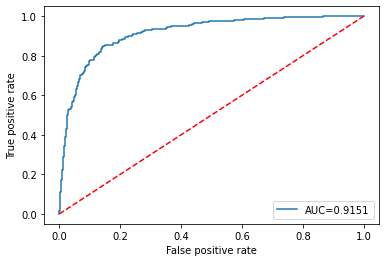

LASSO sentiment classifier:	AUC=0.9151	Accuracy=0.8488


In [114]:
# Estimate LASSO model
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(solver="liblinear", penalty='l1', )
classifier.fit(X_train_bow, y_train)
yhat = classifier.predict_proba(X_test_bow)[:,1]  # output is probability of both classes

# Compute performance
auc, acc, cmat = assess_sentiment_classifier(y_test, yhat)
print("LASSO sentiment classifier:\tAUC={:.4f}\tAccuracy={:.4f}".format(auc, acc))

# Add results to our data frame to keep track of results
df_scores['LASSO'] = [acc, auc]

In [115]:
df_scores

,Lexicon,LASSO
Acc,0.651200,0.848800
AUC,0.736553,0.915056


Very strong performance. It will be hard (spoiler alert: impossible) to beat that benchmark with deep learning. It is a good exercise to think why the linear model performs so well. Critic is easy: no notion of word order, just using counts as feature values, only linear patterns... but AUC equal and above 0.9 speaks for itself. **Why do you think is the result so strong?**

In [116]:
# Clean up memory 
import gc

X_train_bow = None
X_test_bow = None

gc.collect()

8583

<a id="gru"></a>

### 4.2 Deep learning-based text classifiers
If we can use LASSO, we can also use a neural network for sentiment prediction. Session P.II.1 provided us with some flavor developing deep networks in `Keras`. The following part will provide many more examples. They will also introduce us to using recurrent and bidirectional architectures. Luckily, `Keras` makes using these fairly sophisticated neural networks relatively easy. Since our data is already of the right form, that is a sequence of integer, we can start right away and without further preparation with building networks.  

#### Embedding layers
When it comes to textual data, a crucial part of the architecture of a neural network is the **embedding layer**. `Keras` embedding layers support two use cases:
* Learning an embedding as part of network training
* Using pre-trained embeddings

We will illustrate both use cases in the reminder. 

In [117]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, GRU, Flatten
from keras.initializers import Constant

An Embedding is the entry point (i.e., first hidden layer) to a NN for text processing. When creating an embedding layer, you have to specify three arguments:

* input_dim: This is the size of our vocabulary
* output_dim: This is the embedding dimension, or, put differently the size of our word vectors
* input_length: This is the length of our input sequences, i.e., the length of the reviews in words

Knowing that these inputs are crucial further clarifies some previous steps, for example, why we had using padding to ensure a consistent length across all reviews.

In [118]:
# Some variables to centralize the configuration of deep learning models
NB_HIDDEN = 16        # Hidden nodes / state in fedforward / recurrent NNs
EPOCH = 5             # Passes through the entire data set 
BATCH_SIZE = 64 #128  # Batch size
EMBEDDING_DIM = 50    # Embedding dimension
VAL_SPLIT = 0.25      # fraction of the training set used for validation

With these settings, we can create our embedding layer as follows:

In [119]:
# Create an embedding layer
emb_layer = Embedding(input_dim=NUM_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_REVIEW_LENGTH)

#### Model 1: Feed-forward neural network

Once we have an embedding layer, we can move and stack other layers on top of it. Let's first illustrate that approach with a simple feed-forward network. Importantly, the output of the embedding layer will be a matrix: one vector of size equal to the embedding dimension for each word in the input sequence. If we add a fully-connected (**dense**) layer on top of that, we need to **flatten** the output. If the length of a review is 6 and the embedding dimension is 8, then flattening means that we create a 6x8=42 dimension vector, which represents the input to the dense layer.

In [120]:

# Feed-forward neural network
fnn = Sequential()
fnn.add(emb_layer)                           # embedding layer
fnn.add(Flatten())                           # flattening layer (to ensure compliance with the input of the next layer)
fnn.add(Dense(NB_HIDDEN, activation='relu')) # fully-connected layer
fnn.add(Dense(1, activation='sigmoid'))      # output layer (one unit with sigmoid activation of binary classification)

# compile the model
fnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# summarize the model
print(fnn.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 400, 50)           125000    
                                                                 
 flatten_1 (Flatten)         (None, 20000)             0         
                                                                 
 dense_3 (Dense)             (None, 16)                320016    
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 445,033
Trainable params: 445,033
Non-trainable params: 0
_________________________________________________________________
None


In [121]:
# Just for fun, let's recalculate the number of parameters
print('Embedding layer parameters: {}'.format(NUM_WORDS * EMBEDDING_DIM))
print('Flatten layer output shape: {}'.format(MAX_REVIEW_LENGTH * EMBEDDING_DIM))
print('Dense layer parameters: {}'.format(NB_HIDDEN * (MAX_REVIEW_LENGTH * EMBEDDING_DIM)+ NB_HIDDEN))

Embedding layer parameters: 125000
Flatten layer output shape: 20000
Dense layer parameters: 320016


In [122]:
# fitting the model
story = fnn.fit(X_tr_int_pad, y_train, batch_size=BATCH_SIZE, epochs=EPOCH, validation_split=VAL_SPLIT)

Epoch 1/5
44/44 [==============================] - 1s 8ms/step - loss: 0.6952 - accuracy: 0.4957 - val_loss: 0.6928 - val_accuracy: 0.5629
Epoch 2/5
44/44 [==============================] - 0s 6ms/step - loss: 0.6909 - accuracy: 0.5327 - val_loss: 0.6951 - val_accuracy: 0.4648
Epoch 3/5
44/44 [==============================] - 0s 6ms/step - loss: 0.6426 - accuracy: 0.6554 - val_loss: 0.5933 - val_accuracy: 0.7100
Epoch 4/5
44/44 [==============================] - 0s 6ms/step - loss: 0.3173 - accuracy: 0.8933 - val_loss: 0.3772 - val_accuracy: 0.8316
Epoch 5/5
44/44 [==============================] - 0s 6ms/step - loss: 0.0902 - accuracy: 0.9858 - val_loss: 0.3853 - val_accuracy: 0.8294


##### A little bit of infrastructure
The FNN was the first model in a chain of models of increasing sophistication. Sounds promising doesn't it.
Since we are about to train more and more networks, we should develop a little bit of infrastructure code to work with them. Specifically, for each network, we need to produce test set predictions. Also, we would like to examine the development of the loss during training; e.g., to judge whether increasing the number of epochs would make sense. Last, it would be useful to save trained models to disk. After all, we spent quite some time on training them to making a backup in case something goes wrong with out notebook makes a lot of sense. Let's develop some helpers for these tasks.

In [123]:
def diag_nn(model, story, x_ts, y_ts, plot_roc=True, plot_loss=True):
    ''' 
        Diagnose fitted keras models by plotting results from the
        story (e.g., development of training loss) and calculating
        classification performance (accuracy & AUC) on the test set
    '''
    
    # Calculate test set predictions
    yhat = model.predict(X_ts_int_pad)
    
    # Calling our helper for classifier evaluation
    auc, acc, cmat = assess_sentiment_classifier(y_ts, yhat, cut_off=0.5, plot_roc=plot_roc)
    print("NN test set performance:\tAUC={:.4f}\tAccuracy={:.4f}".format(auc, acc))
    print('Confusion matrix:')
    print(cmat)

    if plot_loss:
        plt.plot(story.history['loss'])
        plt.plot(story.history['val_loss'])
        plt.title('loss evolution')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()
    
    return (auc, acc, cmat) 

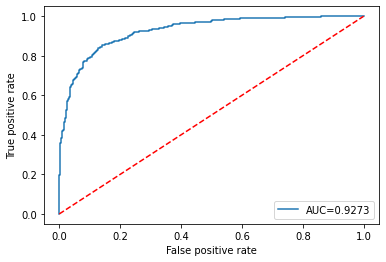

NN test set performance:	AUC=0.9273	Accuracy=0.8504
Confusion matrix:
[[555  77]
 [110 508]]


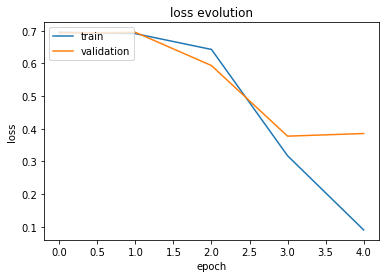

In [124]:
# Assess the performance of the FFN
auc, acc, _ = diag_nn(fnn, story, X_ts_int_pad, y_test, plot_roc=True, plot_loss=True)

# Add results to our data frame to keep track of results
df_scores['FFN'] = [acc, auc]

##### Saving the model to disk
Saving a model is easy. We wrap up the code in a helper function so that we can later store models with one line of code.

In [125]:
# Helper function to save a trained model to disk
def save_mode_to_disk(model, story, fname):
    to_disk = (model, story) # what is to be saved

    with open(fname, 'wb') as file_name:
        pickle.dump(to_disk, file_name)

In [126]:
# Call the function to illustrate storing our FNN
#save_mode_to_disk(fnn, story, 'fnn.pkl')

Just in case, this is how you could load a stored model from disk.

In [127]:
# Load from disk if needed 
#with open('fnn.pkl','rb') as file_name:
 #   model, story = pickle.load(file_name)

#### Model 2: Recurrent neural network based on GRU 
If you felt that the lecture part on advanced RNNs with gated cells was a little complicated you will be pleased to see that using corresponding models is actually quite easy. <br>
**Disclaimer** We do not promise good results to be easily obtained, but getting a GRU to work is not difficult. In fact, it is easy because we already have almost all we need in place. The following codes is almost identical with that of developing the FNN. 
<br>
The only difference is that we use different layers to design a different type of NN, namely a GRU layer. We chose GRU over LSTM because training the former is faster. You can easily adjust the codes to build a LSTM. Simply exchange the type of RNN layer to LSTM. Done.

In [128]:
# GRU text classifier
gru = Sequential()                        
gru.add( Embedding(input_dim=NUM_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_REVIEW_LENGTH) )
gru.add( GRU(NB_HIDDEN) )       
gru.add(Dense(1, activation="sigmoid"))
gru.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
gru.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 400, 50)           125000    
                                                                 
 gru_1 (GRU)                 (None, 16)                3264      
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 128,281
Trainable params: 128,281
Non-trainable params: 0
_________________________________________________________________


In [129]:
story = gru.fit(X_tr_int_pad, y_train, batch_size=BATCH_SIZE, epochs=EPOCH, validation_split=VAL_SPLIT)

Epoch 1/5
44/44 [==============================] - 3s 28ms/step - loss: 0.6891 - accuracy: 0.5594 - val_loss: 0.6811 - val_accuracy: 0.6258
Epoch 2/5
44/44 [==============================] - 1s 17ms/step - loss: 0.6227 - accuracy: 0.7543 - val_loss: 0.5474 - val_accuracy: 0.7377
Epoch 3/5
44/44 [==============================] - 1s 17ms/step - loss: 0.3871 - accuracy: 0.8421 - val_loss: 0.4883 - val_accuracy: 0.7612
Epoch 4/5
44/44 [==============================] - 1s 21ms/step - loss: 0.2672 - accuracy: 0.8986 - val_loss: 0.5239 - val_accuracy: 0.7910
Epoch 5/5
44/44 [==============================] - 1s 20ms/step - loss: 0.1984 - accuracy: 0.9282 - val_loss: 0.4951 - val_accuracy: 0.7900


Revisit the architecture of the GRU and note differences to our first model. We use a **GRU layer** instead of a dense layer. That was simple. Also note that we do not use a flattening layer in this architecture. This hints that the example might give a wrong picture in that it over-simplifies the use of RNNs. The fact that we do not need the flattening layer shows how the GRU layer expects a different input data structure than the dense layer. Specifically, the **expected input structure of RNN-type layers is a 3D tensor** of dimensions
* Samples (batch size)
* Features
* Sequence length 

This is exactly the same data structure that the Embedding layer produces. This is why building the GRU was so easy. When you try building RNN-type networks for other types of data, e.g., to forecast time series, the steps will be a little different and maybe more difficult. Of course many good examples are available online and will guide you if needed. Here is a [good starting point](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/). 
<br>
Over all this talking about GRUs and how they are easy to hard to build, we have forgotten to assess our model. Let's do that and then look at another model.

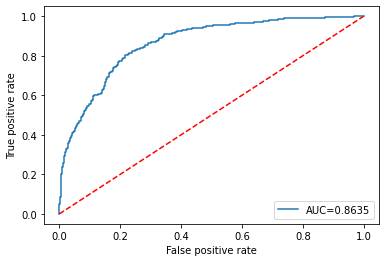

NN test set performance:	AUC=0.8635	Accuracy=0.7912
Confusion matrix:
[[491 141]
 [120 498]]


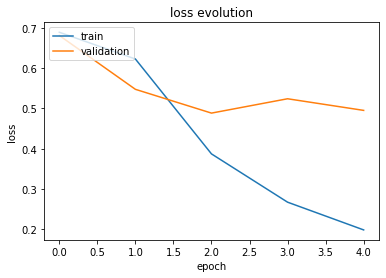

In [130]:
# Assessing the first GRU 
auc, acc, _ = diag_nn(gru, story, X_ts_int_pad, y_test, plot_roc=True, plot_loss=True)

# Add results to our data frame to keep track of results
df_scores['GRU'] = [acc, auc]

# Store the model if you like
# save_mode_to_disk(gru, story, 'gru.pkl')
fnn = None
gru = None

#### Model 3: GRU with pre-trained IMDB embeddings
The previous models incorporated an embedding layer. However, training the weights of these layers, that is learning the word embeddings, was part of training the network. You can imagine that embeddings that you learn on-the-fly while training are different from embeddings that result from a model that is specifically designed to learn embeddings such as Word-to-Vec. Weights in Model 1 and Model 2  including the weights of the embedding matrix were trained to predict review sentiment. Word-to-Vec, on the other hand, solves a different prediction task related to the co-occurrences of words in a pre-defined context window. We have trained corresponding weights in the previous coding session P.II.2. It is about time to put these embeddings into action. Our next model will be similar to the previous one but use our own pre-trained IMDB embeddings resulting from applying the `Gensim` implementation of word-to-vec to our data.  

##### Loading pre-trained embeddings

Let's start with loading the `Gensim` embeddings. A version is available in our shared folder. You could also train your own embeddings using the code from P.II.2.

In [131]:
from gensim.models import KeyedVectors
w2v = KeyedVectors.load_word2vec_format(IMBD_EMBEDDINGS, binary=False)

In [145]:
# Load pretrained W2V embeddings obtained from the IMDB review data set
from gensim.models import KeyedVectors
from gensim.models.keyedvectors import Word2VecKeyedVectors

imdb_index = KeyedVectors.load_word2vec_format(IMBD_EMBEDDINGS, binary=False)

print('Loaded pre-trained embeddings for {} words in {:.0f} sec.'.format(len(imdb_index.vocab), time.time()-start))

Loaded pre-trained embeddings for 30201 words in 339 sec.


Pre-trained embeddings are essentially just a bunch of numbers. Every word has its own bunch of numbers or, more formally, numeric representation. Needless to say, the numbers are supposed to carry meaning, capturing syntactic and semantic relationships between words, etc. The embeddings that we just loaded come in the form of a dictionary. In the dictionary, words serve as the key and the corresponding value is the pre-trained embedding of that word. Let's illustrate this using the word *movie* as an example.  

In [133]:
imdb_index['movie']


array([-0.1822599 , -1.3446348 , -1.2897303 ,  2.8372715 , -1.7880527 ,
       -1.4016911 , -0.40002352, -0.44104162, -1.2055366 ,  1.9156551 ,
       -1.9077121 , -0.39156666,  1.9940598 ,  0.8970286 ,  0.8422975 ,
        0.51421916,  1.463564  ,  0.30327913,  0.21045911,  0.6899226 ,
        6.104059  , -0.44935134,  0.15469474,  1.3334258 ,  2.5855174 ,
       -0.3059417 ,  1.0985308 ,  5.0019836 , -1.4815447 ,  1.0804904 ,
       -2.7110763 , -1.0040046 , -0.4285088 , -2.2910924 ,  0.8414181 ,
        0.45071238,  2.7984192 , -0.0245516 ,  0.7533745 ,  1.7485056 ,
       -2.8679852 ,  1.2919343 , -0.41637954,  0.6801692 ,  1.4475877 ,
        0.7619781 , -0.1511088 , -1.194697  ,  2.4667926 ,  0.83872306,
       -0.80589175, -0.22964178, -2.0997634 ,  1.386016  , -1.5328971 ,
       -0.30052063,  1.6989201 , -2.3403423 ,  1.6581223 ,  1.8864983 ,
       -0.46817195,  3.5043952 , -2.5505664 ,  1.7090949 ,  4.3181653 ,
        1.0591193 , -0.62760025, -0.19465488,  1.9788187 ,  2.06

Having loaded this type of dictionary, our next task is to look-up the embeddings for each of the words in our vocabulary. In simpler terms, for each word that we encounter in our text, we need to look-up its embedding. We will face the same task when working with Glove embeddings later. So let's wrap-up the code in a helper function, which we can reuse later.

In [146]:
def get_embedding_matrix(tokenizer, pretrain, vocab_size, verbose=0):
    '''
        Helper function to construct an embedding matrix for 
        the focal corpus based on some pre-trained embeddings.
    '''
    
    dim = 0
    # We will use the function with different types of embeddings. Therefore, 
    # we need a condition to determine what is the right way of determining
    # the embedding dimension. 
    if isinstance(pretrain, KeyedVectors) or isinstance(pretrain, Word2VecKeyedVectors):
        dim = pretrain.vector_size        
    elif isinstance(pretrain, dict):
        dim = next(iter(pretrain.values())).shape[0]  # get embedding of an arbitrary word
    else:
        raise Exception('{} is not supported'.format(type(pretrain)))
    
    
    # Initialize embedding matrix
    emb_mat = np.zeros((vocab_size, dim))

    # There will be some words in our corpus for which we lack a pre-trained embedding.
    # In this tutorial, we will simply use a vector of zeros for such words. We also keep
    # track of the words to do some debugging if needed
    oov_words = []
    # Below we use the tokenizer object that created our task vocabulary. This is crucial to ensure
    # that the position of a words in our embedding matrix corresponds to its index in our integer
    # encoded input data
    v = len(tokenizer.word_index)
    start = time.time()
    print('Start embedding process for {} words.'.format(v), flush=True)
    
    for word, i in tokenizer.word_index.items():  
        # try-catch together with a zero-initilaized embedding matrix achieves our rough fix for oov words
        try:
            emb_mat[i] = pretrain[word]
        except:
            oov_words.append(word)
        # Some output that the method is still alive
        if i % 5000 == 0 and verbose>0:    
            print('{}/{} words in {} sec'.format(i, v, (time.time()-start)), flush=True)
            
            
    print('Created embedding matrix of shape {} in {} min '.format(emb_mat.shape, (time.time()-start)/60))
    
    print('Encountered {} out-of-vocabulary words.'.format(len(oov_words)))
    return (emb_mat, oov_words)

A few more words on embeddings...

At present, we use embeddings that were obtained from the same corpus, namely the IMDB movie review data set, as the one we are working with right now. That is not common. Typically, the pre-training was done on some other — much larger — corpora. Remember that the very purpose of using pre-trained embeddings is that we hope the pre-trained embeddings to embody some information about word relationships that also prove valuable for our task. The larger the pre-trainind corpus the better. That said, there are some pitfalls that we need to be aware of. For example, when working with two different corpora, that used for pre-training embeddings and that used in the target task, the pre-training corpus will include words that do not appear in our corpus. That is less of a problem. More important, however, our corpus might — and often will — include some words for which we lack an embedding. Addressing this issue in a satisfactory manner is out of the scope of this tutorial. Pre-training an embedding for unknown words is a way forward but not a silver bullet. We will simply apply a rough fix and map out-of-vocabulary words to an embedding vector of zeros. Last, and most importantly, a matrix of pre-trained embeddings functions like a lookup table. The Keras embedding layer will not compute a dot product between a one-hot encoded input word and the embedding matrix because this would be inefficient. Instead, Keras expects to find the embedding of a word with index i in the i'th row of the embedding matrix. Therefore, **it is critical that index of a word in our embedding matrix is the same as in our dictionary of word indices**. Remember that we represent words as integers and sentences as a sequence of integers. Assuming a fictious encoded sentence [2, 44, 21], it would be important that the embedding matrix stores the word vectors of the words, which were mapped to the numbers 2, 44, and 21, respectively, in row 2, 44, and 21, respectively. Make sure you convince yourself that our above helper function achieves this consistency.

Having understood all these details, we can eventually create our embedding matrix using our helper function.

In [147]:
# Create embedding weight matrix
imdb_embeddings, _ = get_embedding_matrix(tok, imdb_index, NUM_WORDS)

Start embedding process for 25659 words.
Created embedding matrix of shape (2500, 100) in 0.0012834469477335613 min 
Encountered 23178 out-of-vocabulary words.


For illustration, let's have a look at the embedding of the word 'movie'.

In [148]:
imdb_embeddings[tok.word_index['movie'],:]

array([-0.1822599 , -1.34463477, -1.28973031,  2.83727145, -1.78805268,
       -1.40169108, -0.40002352, -0.44104162, -1.2055366 ,  1.91565514,
       -1.9077121 , -0.39156666,  1.9940598 ,  0.89702863,  0.84229749,
        0.51421916,  1.46356404,  0.30327913,  0.21045911,  0.68992257,
        6.10405922, -0.44935134,  0.15469474,  1.33342576,  2.58551741,
       -0.3059417 ,  1.09853077,  5.00198364, -1.48154473,  1.08049035,
       -2.71107626, -1.0040046 , -0.42850879, -2.2910924 ,  0.84141809,
        0.45071238,  2.79841924, -0.0245516 ,  0.75337452,  1.74850559,
       -2.86798525,  1.29193425, -0.41637954,  0.68016922,  1.44758773,
        0.76197809, -0.1511088 , -1.19469702,  2.46679258,  0.83872306,
       -0.80589175, -0.22964178, -2.09976339,  1.38601601, -1.53289711,
       -0.30052063,  1.69892013, -2.34034228,  1.6581223 ,  1.88649833,
       -0.46817195,  3.50439525, -2.55056643,  1.70909488,  4.3181653 ,
        1.05911934, -0.62760025, -0.19465488,  1.97881866,  2.06

It's time to build another model, this time using our IMDB embeddings. Specifically, we illustrate how to **initialize the weights** in the `Keras` **embedding layer** with our **pre-trained embeddings**. This is the way in which you use a pre-trained embedding in `Keras`. No matter what type of pre-training embedding you obtained and from where, to use it, you set the embedding layer weights to your embedding matrix. This is why it is so critical to **pay attention to word indices**; just in case we have not mentiond it ;)

In [149]:
# Create an embedding layer using pre-trained embeddings
embedding_layer = Embedding(NUM_WORDS, imdb_embeddings.shape[1], input_length=MAX_REVIEW_LENGTH,  
                            embeddings_initializer=Constant(imdb_embeddings), # this is where the pre-trained embeddings come in
                            trainable=True  # This argument is important!
                         )
gru_imdb = Sequential()
gru_imdb.add(embedding_layer)
#model2.add(Dropout(0.2))
gru_imdb.add(GRU(NB_HIDDEN)) #  dropout=0.1, recurrent_dropout=0.1, for recurring unit and recurrant state
gru_imdb.add(Dense(1, activation="sigmoid"))
gru_imdb.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
gru_imdb.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 400, 100)          250000    
                                                                 
 gru_2 (GRU)                 (None, 16)                5664      
                                                                 
 dense_6 (Dense)             (None, 1)                 17        
                                                                 
Total params: 255,681
Trainable params: 255,681
Non-trainable params: 0
_________________________________________________________________


Since this is the first time we make use of a pre-trained embedding, note in the above code that we highlighted the argument `trainable` when creating our embedding layer. This is an important decision. Do you want that the **pre-trained weights get fine-tuned on your task corpus**? This is what the argument `trainable` allows. You should try out whether fine-tuning raises performance of your model but note that it will increase runtimes.  

Epoch 1/5
44/44 [==============================] - 3s 29ms/step - loss: 0.7164 - accuracy: 0.5281 - val_loss: 0.6766 - val_accuracy: 0.5704
Epoch 2/5
44/44 [==============================] - 1s 18ms/step - loss: 0.6308 - accuracy: 0.6369 - val_loss: 0.6438 - val_accuracy: 0.6258
Epoch 3/5
44/44 [==============================] - 1s 17ms/step - loss: 0.5855 - accuracy: 0.6959 - val_loss: 0.6224 - val_accuracy: 0.6375
Epoch 4/5
44/44 [==============================] - 1s 17ms/step - loss: 0.5462 - accuracy: 0.7340 - val_loss: 0.6000 - val_accuracy: 0.6546
Epoch 5/5
44/44 [==============================] - 1s 17ms/step - loss: 0.5065 - accuracy: 0.7628 - val_loss: 0.5850 - val_accuracy: 0.6812


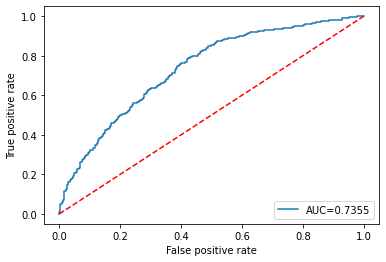

NN test set performance:	AUC=0.7355	Accuracy=0.6632
Confusion matrix:
[[423 209]
 [212 406]]


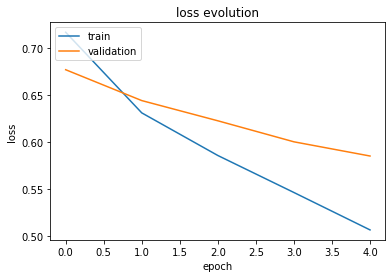

32828

In [150]:
# Train the model 
story = gru_imdb.fit(X_tr_int_pad, y_train, batch_size=BATCH_SIZE, epochs=EPOCH, validation_split=VAL_SPLIT)

# Assessing the first GRU 
auc, acc, _ = diag_nn(gru_imdb, story, X_ts_int_pad, y_test, plot_roc=True, plot_loss=True)

# Add results to our data frame to keep track of results
df_scores['GRU_IMDB'] = [acc, auc]

# Store the model if you like
# save_mode_to_disk(gru_imdb, story, 'gru_imdb.pkl')
gru_imdb = None
imdb_embeddings = None
imdb_index = None
gc.collect()

#### Model 4: GRU with pre-trained GloVe embeddings

Building your own embeddings might not be the smartest thing. In case the vocabulary you will be working with is not too specific, you can always use the pre-trained embeddings that were crafted from very big corpora. GloVe stands for "Global Vectors for Word Representation". It's a somewhat popular embedding technique based on factorizing a matrix of word co-occurrence statistics (https://nlp.stanford.edu/projects/glove/). We could equally stick to W2V and download one of the many available pre-trained versions. There is no specific reason for switching to Glove other than trying out something 'new'. Since the data files of pre-trained embeddings can be quite large, we stick to the smallest available version of Glove, which has an embedding dimension of 50.

**Warning**
Even when using an embedding dimension of just 50, the data that we process in memory gets quite big. You might experience problems when running the code on your own computer (e.g., slow response times). 

In [157]:
# Load GloVe embeddings
# Set the variable to the GLOVE embeddings file on your hard disk. 
# You can download the embeddings from the above URL

glove_index = {}
start = time.time()
i = 0
with open(GLOVE_EMBEDDINGS, 'r', encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        glove_index[word] = coefs
        i += 1
        #if i % 50000 == 0:
            #print('Read {} lines of embeddings in {} sec.'.format(i, time.time()-start))

print('Found {} word vectors after {} sec.'.format(len(glove_index), time.time()-start))

Found 400000 word vectors after 4.68839955329895 sec.


We can re-use our helper function to obtain a proper look-up table for Keras. And that is about it. Everything else is in place so that we can straight go on with building our next classifier. 

In [158]:
# Create matrix with Glove embeddings
# Caution: this operation may take a long time and consume a lot of memory
glove_weights, _ = get_embedding_matrix(tok, glove_index, NUM_WORDS)

Start embedding process for 25659 words.
Created embedding matrix of shape (2500, 50) in 0.0007519801457722982 min 
Encountered 23161 out-of-vocabulary words.


In [159]:
# Embedding layer with the pre-trained GloVe weights
emb_layer = Embedding( NUM_WORDS, EMBEDDING_DIM, input_length=MAX_REVIEW_LENGTH,
                       embeddings_initializer=Constant(glove_weights), 
                       trainable=False  # We consider frozen weights. Play with finetuning the model if you like
                     )

gru_glove = Sequential()
gru_glove.add( emb_layer)
gru_glove.add( GRU(NB_HIDDEN) )
gru_glove.add( Dense(1, activation="sigmoid"))
gru_glove.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
gru_glove.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 400, 50)           125000    
                                                                 
 gru_3 (GRU)                 (None, 16)                3264      
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 128,281
Trainable params: 3,281
Non-trainable params: 125,000
_________________________________________________________________


Epoch 1/5
44/44 [==============================] - 3s 27ms/step - loss: 0.7133 - accuracy: 0.4961 - val_loss: 0.6965 - val_accuracy: 0.5352
Epoch 2/5
44/44 [==============================] - 1s 17ms/step - loss: 0.6832 - accuracy: 0.5491 - val_loss: 0.6857 - val_accuracy: 0.5490
Epoch 3/5
44/44 [==============================] - 1s 16ms/step - loss: 0.6672 - accuracy: 0.5925 - val_loss: 0.6738 - val_accuracy: 0.5885
Epoch 4/5
44/44 [==============================] - 1s 16ms/step - loss: 0.6525 - accuracy: 0.6206 - val_loss: 0.6632 - val_accuracy: 0.6013
Epoch 5/5
44/44 [==============================] - 1s 16ms/step - loss: 0.6319 - accuracy: 0.6486 - val_loss: 0.6355 - val_accuracy: 0.6461


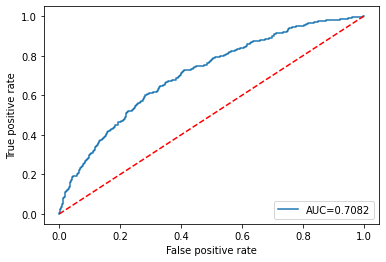

NN test set performance:	AUC=0.7082	Accuracy=0.6528
Confusion matrix:
[[401 231]
 [203 415]]


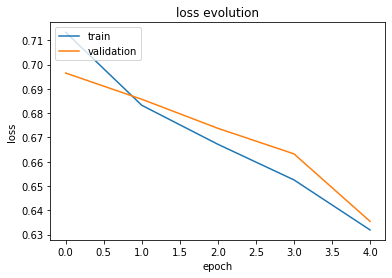

In [160]:
# Train the model 
story = gru_glove.fit(X_tr_int_pad, y_train, batch_size=BATCH_SIZE, epochs=EPOCH, validation_split=VAL_SPLIT)

# Assessing the model
auc, acc, _ = diag_nn(gru_glove, story, X_ts_int_pad, y_test, plot_roc=True, plot_loss=True)

# Add results to our data frame to keep track of results
df_scores['GRU_GloVe'] = [acc, auc]

# Store the model if you like
# save_mode_to_disk(gru_glove, story, 'gru_glove.pkl')
gru_glove = None


#### Model 6: Bidirectional GRU

Ok, we have trained a lot of different models, and to be fair, in terms of programming and how we use Keras, the codes have become quite repetitive. Let's build one last model and conclude. Our last model with be a **bidirectional GRU**. A bidirectional layer is actually two layers with the same structure. Both layers take the input step-by-step, one from beginning to end and one from end-to-beginning. The two hidden states at step 𝑡 are typically merged by concatenating or summing them. In sentiment analysis, the full text is available when making a prediction. Therefore, bidirectional NLP models are feasible. Given their conceptual advantage of having access to both, left and right context, we would expect them to perform a little better. Let's see whether this holds true for our data.  

In [161]:
# Set up Bi-GRU (one new layer but the rest is as above)
from keras.layers import Bidirectional
emb_layer = Embedding(NUM_WORDS, EMBEDDING_DIM, input_length=MAX_REVIEW_LENGTH, 
                         embeddings_initializer=Constant(glove_weights), #weights to start with, and not nouch during training
                         trainable=False  
                     )

bigru = Sequential()
bigru.add( emb_layer ) 
bigru.add(Bidirectional(GRU(NB_HIDDEN), merge_mode="concat"))
bigru.add(Dense(units=1, activation='sigmoid'))
bigru.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
bigru.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 400, 50)           125000    
                                                                 
 bidirectional (Bidirectiona  (None, 32)               6528      
 l)                                                              
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 131,561
Trainable params: 6,561
Non-trainable params: 125,000
_________________________________________________________________


Epoch 1/5
44/44 [==============================] - 5s 46ms/step - loss: 0.7009 - accuracy: 0.4975 - val_loss: 0.6873 - val_accuracy: 0.5405
Epoch 2/5
44/44 [==============================] - 1s 28ms/step - loss: 0.6813 - accuracy: 0.5669 - val_loss: 0.6767 - val_accuracy: 0.5714
Epoch 3/5
44/44 [==============================] - 1s 29ms/step - loss: 0.6663 - accuracy: 0.6056 - val_loss: 0.6635 - val_accuracy: 0.5959
Epoch 4/5
44/44 [==============================] - 1s 29ms/step - loss: 0.6471 - accuracy: 0.6405 - val_loss: 0.6422 - val_accuracy: 0.6301
Epoch 5/5
44/44 [==============================] - 1s 28ms/step - loss: 0.6042 - accuracy: 0.6778 - val_loss: 0.5585 - val_accuracy: 0.7260


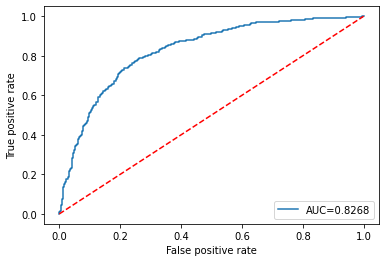

NN test set performance:	AUC=0.8268	Accuracy=0.7600
Confusion matrix:
[[473 159]
 [141 477]]


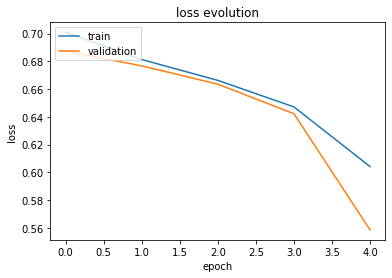

65229

In [162]:
# Train the model 
story = bigru.fit(X_tr_int_pad, y_train, batch_size=BATCH_SIZE, epochs=EPOCH, validation_split=VAL_SPLIT)

# Assessing the model
auc, acc, _ = diag_nn(bigru, story, X_ts_int_pad, y_test, plot_roc=True, plot_loss=True)

# Add results to our data frame to keep track of results
df_scores['BIGRU'] = [acc, auc]

# Store the model if you like
# save_mode_to_disk(bigru, story, 'bigru.pkl')
glove_weights = None
glove_index = None
gc.collect()

## Conclusions
The examples have covered important concepts in deep learning for NLP and text classification. We developed several deep learning-based text classifiers using Keras and advanced our understanding of word embeddings. We also saw examples of how to use pre-trained word embeddings in downstream tasks, such as sentiment analysis. Advancing the code to approach other text classification systems is straightforward. On the other hand, the results of the Keras models are not yet impressive. Here is th overview of the performance over all classifiers developed in the session.

In [163]:
df_scores

,Lexicon,LASSO,FFN,GRU,GRU_IMDB,GRU_GloVe,BIGRU
Acc,0.651200,0.848800,0.850400,0.791200,0.663200,0.6528,0.760000
AUC,0.736553,0.915056,0.927289,0.863496,0.735491,0.7082,0.826802


Considering the performance of the linear model, which is very easy to develop, fast, and memory efficient, we have not yet seen evidence that we need deep learning for the focal sentiment analysis task. It would be a very good exercise and try tuning the more advanced models, starting with proper training for more epochs, to raise their performance and achieve at least competitiveness with the linear model, and maybe the FNN. Good luck ;)